In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
os.environ['THEANO_FLAGS'] = 'device=gpu'
import numpy as np
from keras.layers import *
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential, Model
from keras import backend as K
from keras.optimizers import Adadelta, RMSprop
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2, l1
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

Using Theano backend.
ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
def augment(x):
    x = x.copy()
    ind_z = np.random.choice((0, 1), size=x.shape[0])
    x[ind_z] = x[ind_z, ::-1, :, :]

    ind_y = np.random.choice((0, 1), size=x.shape[0])
    x[ind_y] = x[ind_y, :, ::-1, :]
    
    ind_x = np.random.choice((0, 1), size=x.shape[0])
    x[ind_x] = x[ind_x, :, :, ::-1] 
    return x

class GlobalPooling3D(Layer):

    def __init__(self, dim_ordering='default', **kwargs):
        super(GlobalPooling3D, self).__init__(**kwargs)
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.dim_ordering = dim_ordering
        self.input_spec = [InputSpec(ndim=5)]

    def get_output_shape_for(self, input_shape):
        #if self.dim_ordering == 'tf':
        #    return (input_shape[0], input_shape[3])
        #else:
        return (input_shape[0], input_shape[1])

    def call(self, x, mask=None):
        
        #if self.dim_ordering == 'tf':
        #    return K.mean(x, axis=[1, 2])
        #else:
        return K.mean(x, axis=[2, 3, 4])

    def get_config(self):
        config = {'dim_ordering': self.dim_ordering}
        base_config = super(GlobalPooling3D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
dataset = np.load('../data/train.npz')
X_full = dataset['X']
X_full = X_full.reshape((X_full.shape[0], -1))
y = dataset['y']

X_full = X_full.reshape((X_full.shape[0], 1, 18, 18, 30))
X_full = X_full.transpose((0, 1, 4, 2, 3))
print(X_full.shape)
indices = np.arange(len(X_full))
np.random.shuffle(indices)
X_full = X_full[indices]
y_full = y[indices]

(8300, 1, 30, 18, 18)


(0.92149078845977783, 9.9999227523803711)


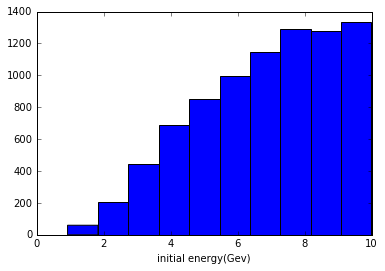

In [8]:
plt.hist(y.flatten())
plt.xlabel('initial energy(Gev)')
print(y.min(),y.max())

In [ ]:
X_train = X_full[0:8000]
y_train = y_full[0:8000]
X_test = X_full[8000:]
y_test = y_full[8000:]

In [ ]:
print(X_full.shape)

In [ ]:
def build_model_conv2d():
    
    inp = Input(shape=(X_full.shape[1], X_full.shape[2], X_full.shape[3], X_full.shape[4]))
    
    x = inp
    x = Reshape((X_full.shape[2], X_full.shape[3], X_full.shape[4]))(x)
    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x)

    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(x)

    x = MaxPooling2D((2, 2))(x)
    
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
    
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)

    x = MaxPooling2D((2, 2))(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x)

    x = GlobalAveragePooling2D()(x)    
    out = Dense(y.shape[1])(x)
    model = Model(input=inp, output=out)
    optimizer = RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

def build_model_conv3d():
    
    inp = Input(shape=(X_full.shape[1], X_full.shape[2], X_full.shape[3], X_full.shape[4]))
    
    x = inp
    
    x = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    
    x = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    
    x = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(x)

    x = MaxPooling3D((2, 2, 2))(x)
    x = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(x)

    x = GlobalPooling3D()(x)    
    out = Dense(y.shape[1])(x)
    model = Model(input=inp, output=out)
    optimizer = RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

In [ ]:
model = build_model_conv2d()
print(model.summary())

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_mean_squared_error',
                  patience=10,
                  verbose=1,
                  mode='auto'),
    # this is used to save the model in a filename
    # it saves only the model at the epoch which gives
    # the best validation accuracy (because we use 'val_acc')
    ModelCheckpoint('model.pkl', monitor='val_mean_squared_error',
                    verbose=1,
                    save_best_only=True,
                    mode='auto'),
]

model.fit(X_train, y_train, 
          validation_split=0.1,
          verbose=2,
          nb_epoch=100,
          callbacks=callbacks)

In [ ]:
train_err = model.history.history['mean_squared_error']
valid_err = model.history.history['val_mean_squared_error']

In [ ]:
plt.plot(train_err, label='train')
plt.plot(valid_err, label='valid')
plt.legend(loc='best')
plt.show()

In [ ]:
model.load_weights('model.pkl') # load the model in the epoch which gave the best validation accuracy
score = model.evaluate(X_test, y_test, verbose=0) # evaluate on test data
print('Test RMSE:', np.sqrt(score[0]))

In [ ]:
d = {'pred': model.predict(X_test).flatten(), 'real': y_test.flatten()}

In [ ]:
pd.DataFrame(d).sample(50)